## 训练LSTM模拟一个简单记忆任务并可视化神经活动

In [3]:
import numpy as np

""" 生成记忆任务的输入与输出的函数 """

def memory_task(seq_len, batch_size, n_repeat=1):

    # 初始化输入和输出序列
    # inputs的数据格式: [seq_len * n_repeat, batch_size, 3]
    # seq_len * n_repeat 为一个trial的时间点数量
    # 之所以seq_len * n_repeat是想表示每seq_len这么长的时间里会进行一次记忆与一次反应
    # 整个trial共进行n_repeat次记忆+反应
    # batch_size 为trial的数量
    # 3代表3种输入units, 分别为stimulus unit、memorize unit、report unit
    # 分别代表视觉输入、要求记忆处、要求反应处
    inputs = np.zeros((seq_len * n_repeat, batch_size, 3))
    outputs = np.zeros((seq_len * n_repeat, batch_size, 1))

    # 对一个trial(batch)中的每个seq_len(共n_repeat个)进行迭代
    for i in range(n_repeat):
        # 当前seq的开始时间
        t_start = i * seq_len
        # 生成随机的stimulus序列
        inputs[t_start:t_start + seq_len, :, 0] = np.random.uniform(-1, 1, size=(seq_len, batch_size))
        # 随机选取seq中一个时间点作为要求记忆处
        t_stim = np.random.randint(int(seq_len) / 2, size=(batch_size,))
        # 随机选取seq中一个时间点作为要求反应处
        t_test = np.random.randint(int(seq_len) / 2, seq_len - 1, size=(batch_size,))
        # 生成memorize序列(要求记忆处值为1，其他时间点为0)
        inputs[t_start + t_stim, range(batch_size), 1] = 1
        # 生成report序列(要求反应处值为1，其他时间点为0)
        inputs[t_start + t_test, range(batch_size), 2] = 1
        # 生成output序列，output对应反应时刻对记忆项的反应，
        # 即在反应时刻与对应seq_len中的stimulus序列中记忆时刻的值一致
        outputs[t_start + t_test, range(batch_size), 0] = inputs[t_start + t_stim, range(batch_size), 0]

    return inputs, outputs

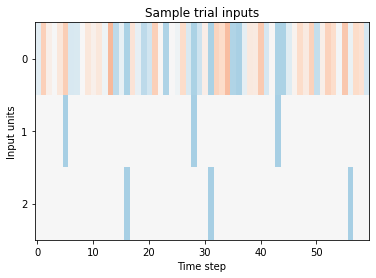

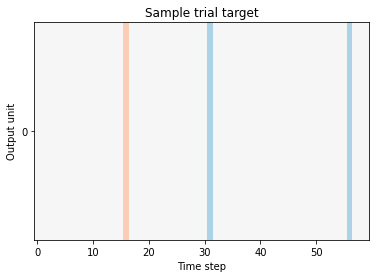

In [4]:
""" 绘制一下输入输出序列 """

import matplotlib.pyplot as plt

# 通过上述函数生成输入输出序列
inputs, outputs = memory_task(seq_len=20, batch_size=32, n_repeat=3)

# 绘制输入序列(包含三种Unit)
plt.figure()
plt.imshow(inputs[:, 0, :].T, aspect='auto', vmin=-3, vmax=3, cmap='RdBu')
plt.title('Sample trial inputs')
plt.xlabel('Time step')
plt.ylabel('Input units')
plt.yticks([0, 1, 2])

# 绘制输出序列
plt.figure()
plt.imshow(outputs[:, 0, :].T, aspect='auto', vmin=-3, vmax=3, cmap='RdBu')
plt.title('Sample trial target')
plt.xlabel('Time step')
plt.ylabel('Output unit')
plt.yticks([0])

plt.show()

###  定义一个LSTM network

In [5]:
from collections import defaultdict
import torch
import torch.nn as nn

class MyLSTM(nn.Module):

    # 构造函数
    def __init__(self, input_size, hidden_size):
        # 调用父类构造函数
        super().__init__()

        # 输入数据的维数
        self.input_size = input_size
        # 输入隐藏层的维数
        self.hidden_size = hidden_size
        # 根据LSTM网络特点，有4个隐含层
        # 输入到进入隐藏层，数据通过input_size到4*hidden_size线性变换
        self.input2h = nn.Linear(input_size, 4 * hidden_size)
        # 隐藏层自连接过程，数据通过hidden_size到4*hidden_size线性变换
        self.h2h = nn.Linear(hidden_size, 4 * hidden_size)
        # readout参数记录是否读出活动
        self.readout = False  # whether to readout activity

    # 帮助循环计算的一个函数
    # input的shape为[number_of_times, batch_size, input_size]
    # hidden包含隐层状态和细胞状态两个部分, 对应hx和cx
    # hx代表根据当前时刻的输入和上一时刻的状态产生的当前时刻的状态值
    # cx代表当前hx中的每个神经元是否会影响下一时刻神经元处理
    # hx和cx的shape均为[batch_size, hidden_size]
    def recurrence(self, input, hidden):

        # 提取当前时刻的h和c
        hx, cx = hidden
        # gates由两个部分组成
        gates = self.input2h(input) + self.h2h(hx)
        # 分为4个gates成分
        # 分别对应input、forget、cell和output
        ingate, forgetgate, cellgate, outgate = gates.chunk(4, dim=1)
        # 为gates设置激活函数
        # LSTM里面包含四种gates，分别为input gate、forget gate、cell gate和output gate
        ingate = torch.sigmoid(ingate)
        forgetgate = torch.sigmoid(forgetgate)
        cellgate = torch.tanh(cellgate)
        outgate = torch.sigmoid(outgate)
        # 计算下一时刻的c和h
        cy = (forgetgate * cx) + (ingate * cellgate)
        hy = outgate * torch.tanh(cy)

        # 当readout为True的时候将网络中的各种activity信息保存在result变量中
        if self.readout:
            result = {
                'ingate': ingate,
                'outgate': outgate,
                'forgetgate': forgetgate,
                'input': cellgate,
                'cell': cy,
                'output': hy,
            }
            return (hy, cy), result
        else:
            return hy, cy

    # 实现LSTM内部连接功能
    def forward(self, input, hidden=None):
        # 获取batch_size
        batch_size = input.shape[1]
        # 初始化hidden
        hidden = (torch.zeros(batch_size, self.hidden_size).to(input.device),
                  torch.zeros(batch_size, self.hidden_size).to(input.device))

        # 当readout为False时，仅返回output和hidden
        # 当readout为True时，返回output、hidden和result
        if not self.readout:
            output = []
            for i in range(input.size(0)):
                hidden = self.recurrence(input[i], hidden)
                output.append(hidden[0])

            # 使用torch.stack函数把结果进行拼接
            output = torch.stack(output, dim=0)
            return output, hidden

        else:
            output = []
            result = defaultdict(list)  # dictionary with default as a list
            for i in range(input.size(0)):
                hidden, res = self.recurrence(input[i], hidden)
                output.append(hidden[0])
                for key, val in res.items():
                    result[key].append(val)

            output = torch.stack(output, dim=0)
            for key, val in result.items():
                result[key] = torch.stack(val, dim=0)

            return output, hidden, result
    
""" 定义一个RNN(基于LSTM) """

class Net(nn.Module):

    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        self.rnn = MyLSTM(input_size, hidden_size, **kwargs)
        # 在LSTM的基础上加上了隐藏层到输出之间的全连接
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        rnn_activity, _ = self.rnn(x)
        out = self.fc(rnn_activity)
        # 返回最终RNN的输出和LSTM的输出(即这里的rnn_activity)
        return out, rnn_activity

### 训练LSTM

In [6]:
import torch.optim as optim

# 初始化RNN，设置相关参数
net = Net(input_size=3, hidden_size=1, output_size=1)

# 使用Adam优化器
optimizer = optim.Adam(net.parameters(), lr=0.01)
criterion = nn.MSELoss()

# 定义loss
running_loss = 0

# 定义打印步长，即每训练500步输出一次loss
print_step = 500

# 进行20000次迭代训练
for i in range(20000):
    # 生成一个随机长度的时间序列
    seq_len = np.random.randint(5, 20)
    # 生成实验条件对应的输入与输出
    inputs, labels = memory_task(seq_len=seq_len, batch_size=16, n_repeat=3)
    # 把输入输出数据转成torch格式
    inputs = torch.from_numpy(inputs).type(torch.float)
    labels = torch.from_numpy(labels).type(torch.float)

    # 梯度初始化为0
    optimizer.zero_grad()   # zero the gradient buffers
    # 该次迭代下的网络输出
    output, activity = net(inputs)

    # 该次迭代的loss
    loss = criterion(output, labels)
    # 反向传播
    loss.backward()
    # 更新权重
    optimizer.step()    # Does the update

    # 获取累计loss
    running_loss += loss.item()
    # 每print_step步打印一次平均loss
    if i % print_step == (print_step - 1):
        running_loss /= print_step
        print('Step {}, Loss {:0.4f}'.format(i+1, running_loss))
        if running_loss < 1e-4:
            break
        running_loss = 0

Step 500, Loss 0.0367
Step 1000, Loss 0.0308
Step 1500, Loss 0.0090
Step 2000, Loss 0.0014
Step 2500, Loss 0.0006
Step 3000, Loss 0.0005
Step 3500, Loss 0.0003
Step 4000, Loss 0.0004
Step 4500, Loss 0.0002
Step 5000, Loss 0.0002
Step 5500, Loss 0.0003
Step 6000, Loss 0.0002
Step 6500, Loss 0.0002
Step 7000, Loss 0.0002
Step 7500, Loss 0.0004
Step 8000, Loss 0.0003
Step 8500, Loss 0.0001
Step 9000, Loss 0.0002
Step 9500, Loss 0.0004
Step 10000, Loss 0.0002
Step 10500, Loss 0.0002
Step 11000, Loss 0.0002
Step 11500, Loss 0.0002
Step 12000, Loss 0.0004
Step 12500, Loss 0.0001
Step 13000, Loss 0.0002
Step 13500, Loss 0.0002
Step 14000, Loss 0.0002
Step 14500, Loss 0.0003
Step 15000, Loss 0.0003
Step 15500, Loss 0.0002
Step 16000, Loss 0.0002
Step 16500, Loss 0.0002
Step 17000, Loss 0.0001
Step 17500, Loss 0.0001
Step 18000, Loss 0.0005
Step 18500, Loss 0.0001
Step 19000, Loss 0.0003
Step 19500, Loss 0.0002
Step 20000, Loss 0.0002


### 模型测试

In [7]:
# 调用训练后的RNN
rnn = net.rnn

# 将RNN的readout参数设为True
rnn.readout = True

# 生成一串任务条件对应的输入输出
# seq_len=50
inputs, labels = memory_task(seq_len=20, batch_size=32, n_repeat=3)
inputs = torch.from_numpy(inputs).type(torch.float)

# 强制不进行反向传播时的自动求导
# 当然"with torch.no_grad()"不影响结果，但是能节约显存
with torch.no_grad():
    # 获取LSTM的返回结果以及经过一个全连接后的最终输出结果
    rnn_activity, _, result = rnn(inputs)
    outputs = net.fc(rnn_activity).detach()

### 可视化神经活动

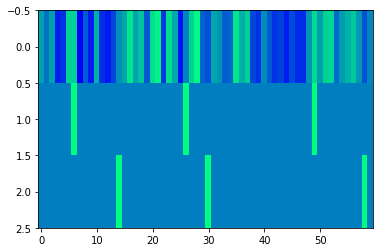

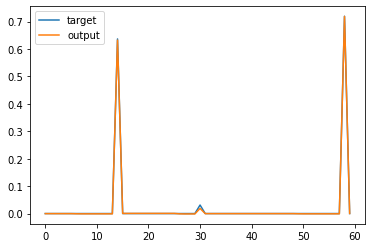

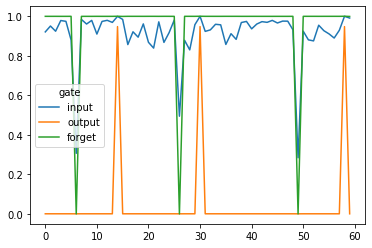

In [8]:
# 对结果绘制
inputs = inputs.numpy()
outputs = outputs.numpy()
i_trial = 0
plt.figure()
plt.imshow(inputs[:, i_trial, :].T, aspect='auto', cmap='winter')

plt.figure()
plt.plot(labels[:, i_trial, 0], label='target')
plt.plot(outputs[:, i_trial, 0], label='output')
plt.legend()

plt.figure()
plt.plot(result['ingate'].numpy()[:, i_trial, 0], label='input')
plt.plot(result['outgate'].numpy()[:, i_trial, 0], label='output')
plt.plot(result['forgetgate'].numpy()[:, i_trial, 0], label='forget')
plt.legend(title='gate')
plt.show()